# 基于维基百科的词向量构建

## Step-01: Download Wikipedia Chinese Corpus: https://dumps.wikimedia.org/zhwiki/20190720/

```
wget https://dumps.wikimedia.org/zhwiki/20190720/zhwiki-20190720-pages-articles-multistream.xml.bz2
```

## Step-02: Using https://github.com/attardi/wikiextractor to extract the wikipedia corpus

- 1 使用WikiCorpus抽取语料库

In [ ]:
import logging
import sys
from gensim.corpora import WikiCorpus
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level=logging.INFO)
'''
    extract data from wiki dumps(*articles.xml.bz2) by gensim.
'''
def help():
    print("Usage: python wiki_corpus.py zhwiki-20190720-pages-articles-multistream.xml.bz2 zhwiki.txt")

if __name__ == '__main__':
    if len(sys.argv) < 3:
        help()
        sys.exit(1)
    logging.info("running %s" % ' '.join(sys.argv))
    inp, outp = sys.argv[1:3]
    i = 0

    output = open(outp, 'w',encoding='utf8')
    wiki = WikiCorpus(inp, lemmatize=False, dictionary={})
    for text in wiki.get_texts():
        output.write(" ".join(text) + "\n")
        i = i + 1
        if (i % 10000 == 0):
            logging.info("Save "+str(i) + " articles")
    output.close()
    logging.info("Finished saved "+str(i) + "articles")

- 2 使用opencc转为简体中文

In [ ]:
import logging
import sys
from opencc import OpenCC
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level=logging.INFO)
'''
    conver data from traditional to simplize by opencc.
'''
def help():
    print("Usage: python opencc_simple.py zhwiki.txt zhwiki_simple.txt")

if __name__ == '__main__':
    if len(sys.argv) < 3:
        help()
        sys.exit(1)
    logging.info("running %s" % ' '.join(sys.argv))
    inp, outp = sys.argv[1:3]
    i = 0

    output = open(outp, 'w', encoding='utf8')
    input = open(inp, 'r', encoding='utf8')
    cc = OpenCC('t2s')
    for line in input:
        converted = cc.convert(line)
        output.write(converted + "\n")
        i = i + 1
        if (i % 10000 == 0):
            logging.info("Save "+str(i) + " articles")
    output.close()
    logging.info("Finished saved "+str(i) + "articles")

- 3 只保留中文，并用jieba分词

In [ ]:
import re
import jieba

f_in = open('zhwiki_simple.txt', 'r', encoding='utf8')
f_out = open('zhwiki_only_simple_and_cut.txt', 'w', encoding='utf8')
line = f_in.readline()

while line:
    if line == '\n':
        line = f_in.readline()
        continue
    pattern = re.compile('[\u4E00-\u9FA5]')
    result = pattern.findall(line)
    line = ''.join(result)
    line = jieba.cut(line)
    new_line = ' '.join(line)
    f_out.writelines(new_line)
    f_out.write('\n')
    line = f_in.readline()

f_in.close()
f_out.close()

## Step-03: Using gensim get word vectors:

### gensim训练模型

In [29]:
import sys
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import multiprocessing

corpus_line = word2vec.LineSentence('zhwiki_only_simple_and_cut.txt')
cbow_model = word2vec.Word2Vec(corpus_line, size=200, window=5, min_count=5, workers=4)
cbow_model.save("cbow_word2vec.model")
skip_gram_model_10000 = word2vec.Word2Vec(corpus_line, size=200, window=10, min_count=10000, sg=1, workers=4)
skip_gram_model_10000.save("skip_gram_word2vec_10000.model")
cbow_model_10000 = word2vec.Word2Vec(corpus_line, size=200, window=5, min_count=10000, workers=4)
cbow_model_10000.save("cbow_word2vec_10000.model")


## Step-04: 使用词向量模型测试同义词

In [1]:
from gensim.models import Word2Vec
zh_wiki_word2vec_model = Word2Vec.load('cbow_word2vec_10000.model')

In [2]:
zh_wiki_word2vec_model.wv.most_similar(u"足球")

[('篮球', 0.6268117427825928),
 ('俱乐部', 0.576410174369812),
 ('联赛', 0.5368397235870361),
 ('体育', 0.5324668884277344),
 ('教练', 0.48269015550613403),
 ('球', 0.48210930824279785),
 ('杯', 0.48172301054000854),
 ('球员', 0.4620283246040344),
 ('世界杯', 0.4544873833656311),
 ('运动员', 0.4519582986831665)]

In [3]:
zh_wiki_word2vec_model.wv.most_similar(u"上海")

[('北京', 0.7892472147941589),
 ('天津', 0.7150691747665405),
 ('杭州', 0.7140796184539795),
 ('南京', 0.7014510631561279),
 ('广州', 0.6923811435699463),
 ('重庆', 0.6729135513305664),
 ('武汉', 0.6317613124847412),
 ('青岛', 0.587638258934021),
 ('西安', 0.5655662417411804),
 ('江苏', 0.5629956126213074)]

## Step-05: 词向量可视化

https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

D:\Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


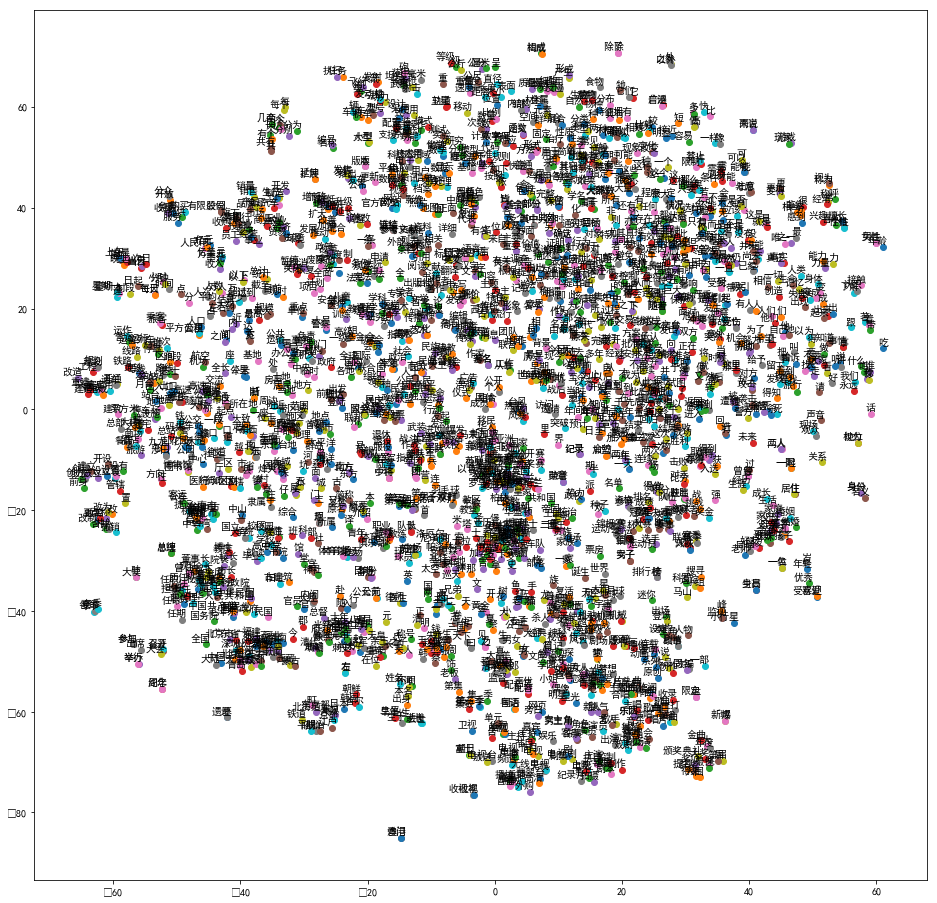

In [7]:
tsne_plot(zh_wiki_word2vec_model)